# Tutorial

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch

import cellrank as cr
import scvi

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

from velovi import preprocess_data
import regvelo
from regvelo import REGVELOVI,sanity_check,set_prior_grn,abundance_test,TFscreening

In [2]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


## Load data

In [3]:
adata = regvelo.datasets.zebrafish_nc()
prior_net = regvelo.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

100%|██████████| 40.2M/40.2M [00:00<00:00, 97.9MB/s]


In [4]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


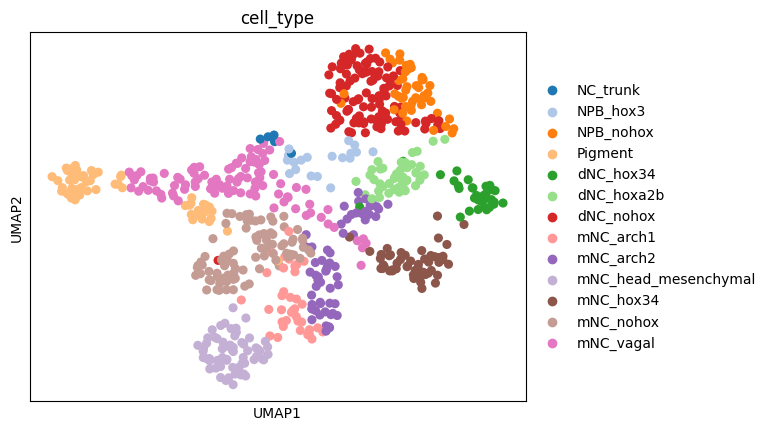

In [5]:
sc.pl.umap(adata, color='cell_type',palette=sc.pl.palettes.vega_20)

## Preprocessing

In [6]:
adata = preprocess_data(adata)
adata = set_prior_grn(adata,prior_net)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TF: "+str(len(TF_list)))

final number of TF: 81


In [8]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [9]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.052775327


## Training RegVelo model

In [10]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,regulators = TF_list,soft_constraint = False)

In [11]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/en

Epoch 1410/1500:  94%|█████████▍| 1410/1500 [09:29<00:36,  2.48it/s, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2406.869. Signaling Trainer to stop.


In [12]:
adata_target = reg_vae.add_regvelo_outputs_to_adata(adata = adata)

In [13]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/112 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Predict terminal states

100%|██████████| 697/697 [00:00<00:00, 1588.77cell/s]


Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 82.11/s]


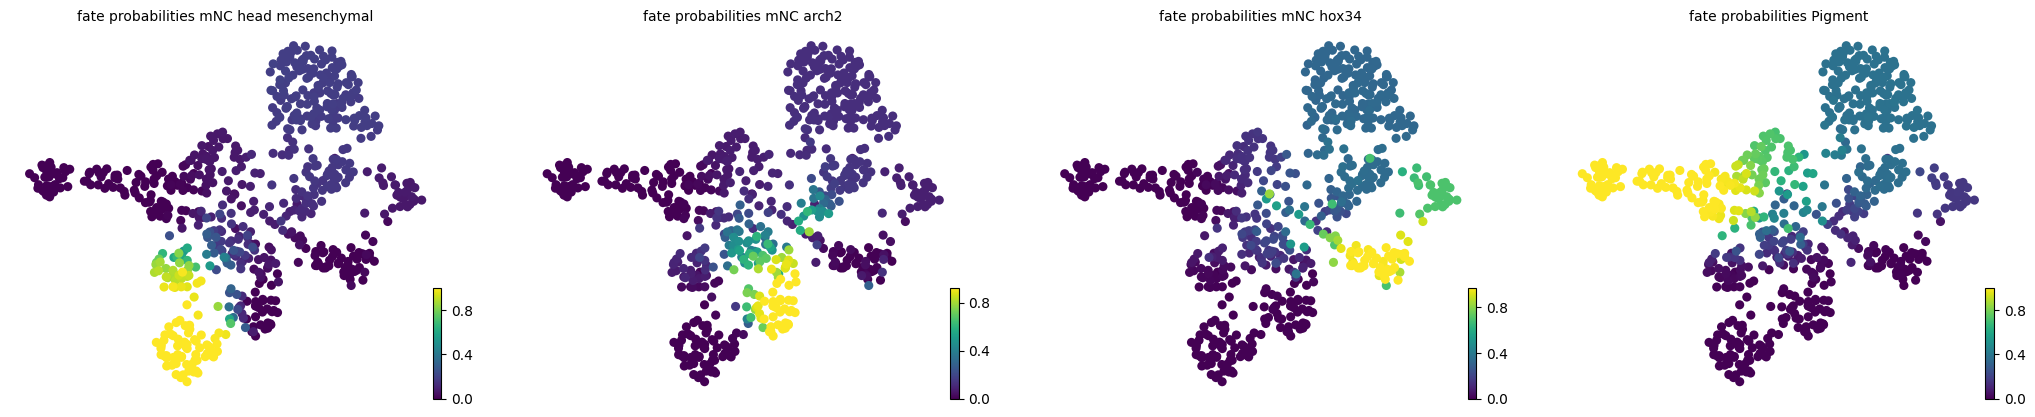

In [14]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata_target).compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7,cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs

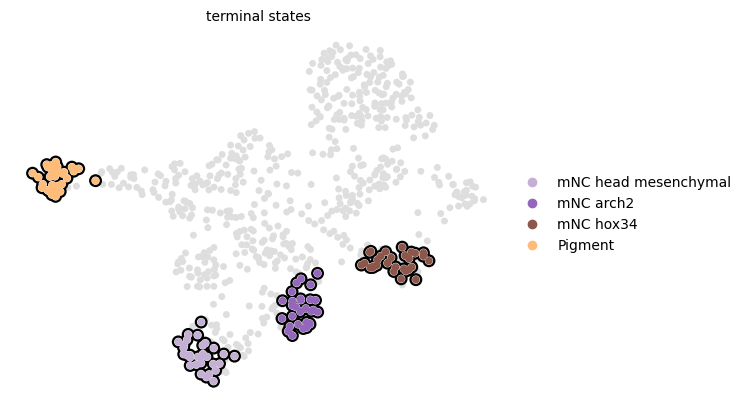

In [15]:
estimator.plot_macrostates(which="terminal", legend_loc="right", s=100)

## Save model

In [16]:
reg_vae.save("rgv_model")

## Perform perturbation screening

In [17]:
fate_prob_perturb = []
cand_list = ["nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2b"]
for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb,reg_vae_perturb =  regvelo.in_silico_block_simulation(model,adata,TF,cutoff = 0)
    ### predict the terminal state dfference
    n_states = 7
    vk = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    estimator.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    estimator.set_terminal_states(terminal_states)
    estimator.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())

    fate_prob_perturb.append(cond1_df)

INFO     File rgv_model/model.pt already downloaded                                                                


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1549.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 77.90/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1611.33cell/s]


100%|██████████| 4/4 [00:00<00:00, 82.36/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1486.27cell/s]


100%|██████████| 4/4 [00:00<00:00, 79.86/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1503.98cell/s]


100%|██████████| 4/4 [00:00<00:00, 79.27/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1380.26cell/s]


100%|██████████| 4/4 [00:00<00:00, 78.46/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1514.67cell/s]


100%|██████████| 4/4 [00:00<00:00, 75.29/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1403.14cell/s]


100%|██████████| 4/4 [00:00<00:00, 79.36/s]

INFO     File rgv_model/model.pt already downloaded                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1471.60cell/s]


100%|██████████| 4/4 [00:00<00:00, 80.65/s]


In [18]:
cond2_df = pd.DataFrame(adata_target.obsm["lineages_fwd"], columns=adata_target.obsm["lineages_fwd"].names.tolist())
df = []
for i in range(len(fate_prob_perturb)):
    data = abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame(
        {
            "Score": data.iloc[:, 0].tolist(),
            "p-value": data.iloc[:, 1].tolist(),
            "Terminal state": data.index.tolist(),
            "TF": [cand_list[i]] * (data.shape[0]),
        }
    )
    df.append(data)

df = pd.concat(df)

df["Score"] = (0.5 - df["Score"])*2

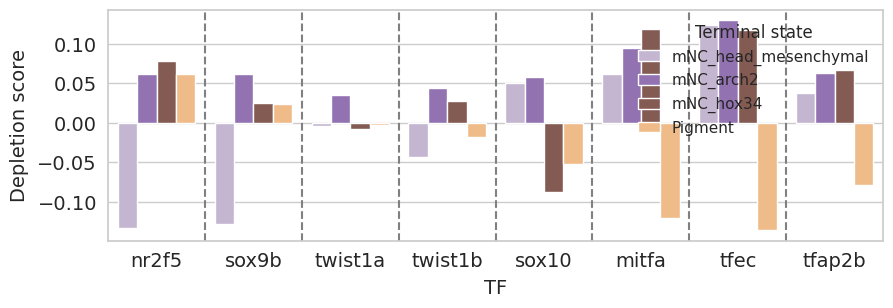

In [19]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Depletion score', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels
    plt.show()

## Screening different KO combination

In [20]:
KO_list = ["tfec","mitfa","fli1a_sox9b","nr2f5"]
perturb_likelihood,perturb_pval = TFscreening(adata = adata,
            prior_graph = W.T,
            soft_constraint = False,
            TF_list = TF,
            cluster_label = "cell_type",
            terminal_states = terminal_states,
            KO_list = KO_list,
            n_states = 8,
            cutoff = 0)

training model...


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/en

Epoch 1249/1500:  83%|████████▎ | 1249/1500 [08:25<01:41,  2.47it/s, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2410.081. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1520.88cell/s]


100%|██████████| 4/4 [00:00<00:00, 72.31/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1355.46cell/s]


100%|██████████| 4/4 [00:00<00:00, 75.45/s]

Done tfec
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 879.56cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.76/s]

Done mitfa
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1500.55cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.57/s]

Done fli1a_sox9b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      



/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1409.91cell/s]

100%|██████████| 4/4 [00:00<00:00, 77.61/s]


Done nr2f5


In [21]:
2*(0.5 - perturb_likelihood)

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a_sox9b,-0.165631,-0.069976,0.082174,0.065859
mitfa,0.036811,0.076221,0.110963,-0.108539
nr2f5,-0.121622,0.064225,0.073245,0.043077
tfec,0.113742,0.114446,0.114096,-0.133466
